This analysis does the following:
- extracts CNN and FOX articles
- Loads text for respective articles
- breaks CNN and FOX NEWS articles down into bigrams and trigrams
    - displays charts for each
- Analyze polarity and subjectivity for top n-grams in each category

In [68]:
!pip install textblob
!pip install WordCloud

You should consider upgrading via the '/opt/homebrew/anaconda3/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 220 kB 7.4 MB/s eta 0:00:01
  Created wheel for WordCloud: filename=wordcloud-1.8.1-cp38-cp38-macosx_10_9_x86_64.whl size=158421 sha256=1b362b93405a06727a36446ef9b8d3cecc1342a9b3bbcae941588b85364867ff
  Stored in directory: /Users/lithplus/Library/Caches/pip/wheels/4d/3f/0d/a2ba9b7895c9f1be89018b3141c3df3d4f9c786c882ccfbc3b
Successfully built WordCloud
You should consider upgrading via the '/opt/homebrew/anaconda3/bin/python -m pip install --upgrade pip' command.


In [69]:
import os
os.chdir("..")

from data.nela2017 import Nela2017
from utils.text.preprocess import preprocess, STOPWORDS
# from utils.text.analysis import sentiment
from utils.plotting.plotting import box_and_whisker
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from textblob import TextBlob
from nltk.util import bigrams, trigrams
from sklearn.feature_extraction.text import CountVectorizer
import nltk

In [70]:
sns.set_theme()

In [71]:
ROOT = "/Users/lithplus/Documents/news-bias-analysis/notebooks/data"  # change to wherever you have the data

In [72]:
dataset = Nela2017(ROOT)

In [73]:
dataset.organizations("FOX NEWS", "CNN")
df = dataset.df()

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4776 non-null   object
 1   path    4776 non-null   object
 2   org     4776 non-null   object
 3   date    4776 non-null   object
 4   title   4776 non-null   object
 5   text    4776 non-null   object
 6   author  4776 non-null   object
dtypes: object(7)
memory usage: 261.3+ KB


In [75]:
df["text_pp"] = df["text"].apply(preprocess).apply(lambda x: " ".join(x))

In [76]:
df["tokens"] = df["text_pp"].apply(nltk.word_tokenize)

In [77]:
df["polarity"] = df['text_pp'].apply(lambda x: TextBlob(x).polarity)
df["polarity"]

0       0.072025
1       0.018519
2       0.046971
3       0.147321
4       0.116000
          ...   
4771    0.077696
4772   -0.011293
4773    0.125206
4774    0.095881
4775    0.027611
Name: polarity, Length: 4776, dtype: float64

In [78]:
df["subjectivity"] = df['text_pp'].apply(lambda x: TextBlob(x).subjectivity)
df["subjectivity"]

0       0.384938
1       0.251235
2       0.296943
3       0.367857
4       0.339333
          ...   
4771    0.307419
4772    0.344770
4773    0.498707
4774    0.546748
4775    0.445218
Name: subjectivity, Length: 4776, dtype: float64

In [79]:
c_vec = CountVectorizer(stop_words=STOPWORDS, ngram_range=(2,))
df["bigrams"] = df["tokens"].apply(lambda x: tuple(bigrams(x)))
df["trigrams"] = df["tokens"].apply(lambda x: tuple(trigrams(x)))

In [80]:
df["trigrams"]

0       ((realDonaldTrump, bringing, auto), (bringing,...
1       ((President, Donald, Trump), (Donald, Trump, m...
2       ((CNN, The, House), (The, House, Intelligence)...
3       ((The, Vermont, senator), (Vermont, senator, a...
4       ((But, Friday, afternoon), (Friday, afternoon,...
                              ...                        
4771    ((Washington, CNN, Trump), (CNN, Trump, admini...
4772    ((CNN, Former, Trump), (Former, Trump, campaig...
4773    ((CNN, Whether, Ed), (Whether, Ed, Gillespie),...
4774    ((In, US, Air), (US, Air, Force), (Air, Force,...
4775    ((At, first, glance), (first, glance, Presiden...
Name: trigrams, Length: 4776, dtype: object

In [97]:
og_df = df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4776 entries, 0 to 4775
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            4776 non-null   object 
 1   path          4776 non-null   object 
 2   org           4776 non-null   object 
 3   date          4776 non-null   object 
 4   title         4776 non-null   object 
 5   text          4776 non-null   object 
 6   author        4776 non-null   object 
 7   text_pp       4776 non-null   object 
 8   tokens        4776 non-null   object 
 9   polarity      4776 non-null   float64
 10  subjectivity  4776 non-null   float64
 11  bigrams       4776 non-null   object 
 12  trigrams      4776 non-null   object 
dtypes: float64(2), object(11)
memory usage: 485.2+ KB


In [82]:
def extract_trigrams(df, kw):
    trigrams = []
    for trigram_group in df.trigrams:
        for trigram in trigram_group:
            for word in trigram:
                if kw.lower() in word.lower():
                    trigrams.append(trigram)
                    break
    return trigrams


def trigram_sentiment(df, kw, org=None):
    if org is not None:
        df = df[df.org.str.lower() == org.lower()]
    
    trigrams = extract_trigrams(df, kw)
    
    polarities = []
    subjectivities = []
    for trigram in trigrams:
        text = " ".join(trigram)
        polarity = TextBlob(text).polarity
        subjectivity = TextBlob(text).subjectivity
        if polarity != 0:
            polarities.append(polarity)
        if subjectivity != 0:
            subjectivities.append(subjectivity)
    
    result = {
        "polarity": polarities, 
        "subjectivity": subjectivities
    }
    return result
    
    
def text_sentiment(df, kw, org=None):
    if org is not None:
        df = df[df.org.str.lower() == org.lower()]
    
    result = {
        "polarity": list(df.polarity),
        "subjectivity": list(df.subjectivity)
    }
    
    return result


def sentence_sentiment(df, kw, org=None):
    if org is not None:
        df = df[df.org.str.lower() == org.lower()]
    
    
    polarities = []
    subjectivities = []
    
    series = df["text"].str.split('.')
    for sentences in series:
        for sentence in sentences:
            text = preprocess(sentence, tokenized=False)
            polarity = TextBlob(text).polarity
            subjectivity = TextBlob(text).subjectivity
            polarities.append(polarity)
            subjectivities.append(subjectivity)
            
    result = {
        "polarity": list(df.polarity),
        "subjectivity": list(df.subjectivity)
    }
    
    return result

In [83]:
trigram_cnn = trigram_sentiment(df, "trump", org="CNN")
trigram_fox = trigram_sentiment(df, "trump", org="FOX NEWS")

In [84]:

text_fox = text_sentiment(df, "trump", org="FOX NEWS")
text_cnn = text_sentiment(df, "trump", org="CNN")

In [92]:
fox_sentiment = sentence_sentiment(df, "trump", org="FOX NEWS")
cnn_sentiment = sentence_sentiment(df, "trump", org="FOX NEWS")

In [94]:
import seaborn as sns

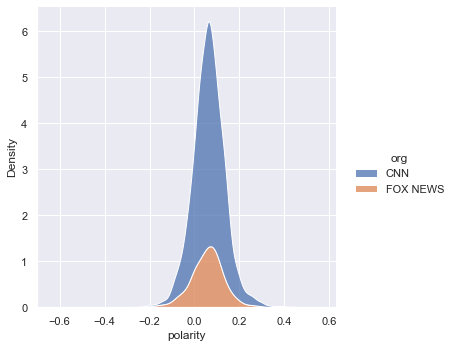

In [98]:
sns.displot(df, x = "polarity", hue = "org",kind = "kde", multiple = "stack")

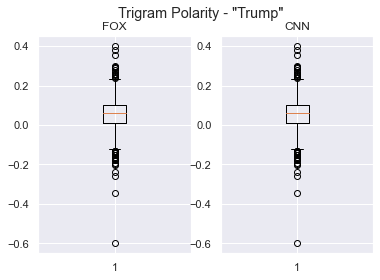

In [93]:
fig, axs = plt.subplots(1, 2)

box_and_whisker(fox_sentiment["polarity"], ax=axs[0])
box_and_whisker(cnn_sentiment["polarity"], ax=axs[1])

fig.suptitle("Trigram Polarity - \"Trump\"")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()

In [88]:
fig, axs = plt.subplots(1, 2)

box_and_whisker(fox_sentiment["subjectivity"], ax=axs[0])
box_and_whisker(cnn_sentiment["subjectivity"], ax=axs[1])

fig.suptitle("Trigram Subjectivity - \"Trump\""")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()

SyntaxError: EOL while scanning string literal (<ipython-input-88-5ce9fc614bfc>, line 6)

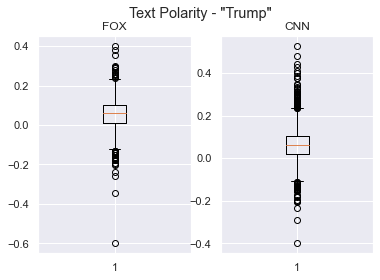

In [89]:
fig, axs = plt.subplots(1, 2)

box_and_whisker(text_fox["polarity"], ax=axs[0])
box_and_whisker(text_cnn["polarity"], ax=axs[1])

fig.suptitle("Text Polarity - \"Trump\"")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()

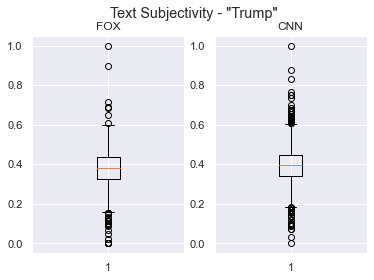

In [90]:
fig, axs = plt.subplots(1, 2)

box_and_whisker(text_fox["subjectivity"], ax=axs[0])
box_and_whisker(text_cnn["subjectivity"], ax=axs[1])

fig.suptitle("Text Subjectivity - \"Trump\"")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()

NameError: name 'sentence_fox' is not defined

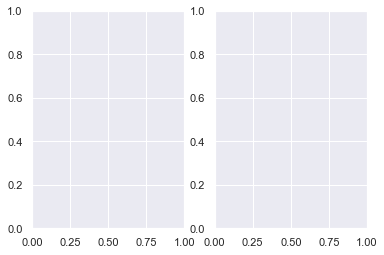

In [91]:
# sentence_fox = sentence_sentiment(df, "trump", org="FOX NEWS")
# sentence_cnn = sentence_sentiment(df, "trump", org="CNN")


fig, axs = plt.subplots(1, 2)

box_and_whisker(sentence_fox["polarity"], ax=axs[0])
box_and_whisker(sentence_cnn["polarity"], ax=axs[1])

fig.suptitle("Sentence Polarity - \"Trump\"")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()
fig, axs = plt.subplots(1, 2)

box_and_whisker(sentence_fox["subjectivity"], ax=axs[0])
box_and_whisker(sentence_cnn["subjectivity"], ax=axs[1])

fig.suptitle("Sentence Subjectivity - \"Trump\"")
axs[0].set_title("FOX")
axs[1].set_title("CNN")
plt.show()